# Setup

## Libraries

In [110]:
# !pip install osmnx
# !pip install langdetect

In [191]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import re
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import time
import geopandas as gpd
import osmnx as ox
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from scipy import spatial
from shapely import wkt
from IPython.display import display
from langdetect import detect
from scipy.stats import shapiro
from scipy import stats
from scipy.stats import norm
import matplotlib
sns.set()

import warnings
warnings.filterwarnings('ignore')

## Display preferences

In [112]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 1000)

# pd.reset_option('display.max_colwidth')
# pd.set_option('display.max_colwidth', None)

## Some functions

In [113]:
def equal_columns(df):
    equal_columns = []
    columns = df.columns

    for i, col1 in enumerate(columns):
        for j in range(i + 1, len(columns)):
            col2 = columns[j]
            if (df[col1] == df[col2]).all():
                equal_columns.append((col1, col2))
    return equal_columns

def one_value_columns(df):
    one_value_cols = df.nunique()[df.nunique() == 1].index
    return one_value_cols

def unique_values_col(df):
    cols = df.columns
    print('columns having unique values for each row:')
    for x in cols:
        if len(df[x].unique())==df.shape[0]:
            print(x)

# Import the data

In [114]:
# read in the detailed listing data
df_listing = pd.read_csv('http://data.insideairbnb.com/united-kingdom/england/london/2023-03-14/data/listings.csv.gz', encoding='utf-8')

print(df_listing.shape)
df_listing.head(1)

(75241, 75)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,714569379355913481,https://www.airbnb.com/rooms/714569379355913481,20230314070633,2023-03-14,city scrape,Lovely private bedroom in Muswell Hill.,Take a break and unwind at this peaceful oasis.,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,39009854,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN


# Clean the data

In [115]:
df_listing['price'].isnull().sum()

0

## Remove columns that have all null values

In [116]:
all_nulls_cols = df_listing.columns[df_listing.isnull().all()].tolist()
all_nulls_cols

['neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated', 'license']

In [117]:
df_listing = df_listing.dropna(how='all', axis=1)
df_listing.shape

(75241, 71)

## Format price to numerical values

In [118]:
df_listing['price'].head()

0    $100.00
1     $65.00
2    $132.00
3    $100.00
4    $120.00
Name: price, dtype: object

In [119]:
df_listing['price'] = df_listing['price'].str[1:-3]
df_listing['price'] = df_listing['price'].str.replace(",", "")
df_listing['price'] = df_listing['price'].astype(float)
df_listing['price'].head()

0    100.0
1     65.0
2    132.0
3    100.0
4    120.0
Name: price, dtype: float64

## Keep only the rows with positive prices

In [120]:
df_listing['price'].describe().round(2)

count    75241.00
mean       175.73
std        487.36
min          0.00
25%         60.00
50%        100.00
75%        180.00
max      70111.00
Name: price, dtype: float64

In [121]:
(df_listing['price']==0).sum()

14

In [122]:
df_listing = df_listing[df_listing['price']>0]
df_listing.shape

(75227, 71)

## Keep only the listings that have received one or more reviews in the last 12 months

`number_of_reviews_ltm`: The number of reviews the listing has (in the last 12 months)

In [123]:
df_listing = df_listing[df_listing['number_of_reviews_ltm']>0]
df_listing.shape

(36636, 71)

In [124]:
# df_listing.room_type.value_counts()

## Remove some columns

### Remove variables with unique values for each row

In [125]:
unique_values_col(df_listing)

columns having unique values for each row:
id
listing_url


In [126]:
df_listing['listing_url'].describe()

count                                               36636
unique                                              36636
top       https://www.airbnb.com/rooms/825491308329325404
freq                                                    1
Name: listing_url, dtype: object

In [127]:
# df_listing[['id']].head()
# df_listing['id'].dtype

### Remove columns with only one value

In [128]:
one_value_columns(df_listing)

Index(['scrape_id'], dtype='object')

In [129]:
df_listing['scrape_id'].value_counts()

20230314070633    36636
Name: scrape_id, dtype: int64

### Scraped date columns

In [130]:
df_listing['last_scraped'].value_counts()

2023-03-14    18457
2023-03-15    14714
2023-03-16     3429
2023-03-29       36
Name: last_scraped, dtype: int64

In [131]:
df_listing['calendar_last_scraped'].value_counts()

2023-03-14    18460
2023-03-15    14715
2023-03-16     3425
2023-03-29       36
Name: calendar_last_scraped, dtype: int64

In [132]:
df_listing.drop(columns=[
    'scrape_id','last_scraped','calendar_last_scraped'], inplace=True)
df_listing.set_index('id', inplace=True)

In [133]:
print(df_listing.shape)
df_listing.head(1)

(36636, 67)


,listing_url,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
825491308329325404,https://www.airbnb.com/rooms/825491308329325404,city scrape,Cosy room with own bathroom,Spacious room,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,500808473,https://www.airbnb.com/users/show/500808473,Ekaterina,2023-02-12,...,4.67,5.0,4.67,4.67,f,1,0,1,0,3.0


## Convert percentages from strings (98%) to numbers (0.98)

In [134]:
df_listing[['host_response_rate','host_acceptance_rate']].head()

,host_response_rate,host_acceptance_rate
id,,
825491308329325404,100%,100%
786791705194673775,98%,87%
749834503531737273,100%,100%
717113207077160928,100%,100%
50584271,100%,93%


In [135]:
df_listing[['host_response_rate','host_acceptance_rate']].describe()

,host_response_rate,host_acceptance_rate
count,33120,36231
unique,75,98
top,100%,100%
freq,24379,11821


In [136]:
# df_listing[['host_response_rate']].value_counts()
# df_listing[['host_acceptance_rate']].value_counts()

In [137]:
df_listing[['host_acceptance_rate','host_response_rate']].dtypes

host_acceptance_rate    object
host_response_rate      object
dtype: object

In [138]:
# removing the '%', converting to integer and dividing by 100

df_listing['host_response_rate'] = df_listing['host_response_rate'].apply(
    lambda x: int(x[:len(x)-1])/100 if isinstance(x,str) else x)
df_listing['host_acceptance_rate'] = df_listing['host_acceptance_rate'].apply(
    lambda x: int(x[:len(x)-1])/100 if isinstance(x,str) else x)

df_listing[['host_response_rate','host_acceptance_rate']].head()

,host_response_rate,host_acceptance_rate
id,,
825491308329325404,1.00,1.00
786791705194673775,0.98,0.87
749834503531737273,1.00,1.00
717113207077160928,1.00,1.00
50584271,1.00,0.93


In [139]:
# df_listing[['host_acceptance_rate','host_response_rate']].dtypes

In [140]:
df_listing[['host_acceptance_rate','host_response_rate']].describe().round(2)

,host_acceptance_rate,host_response_rate
count,36231.00,33120.00
mean,0.88,0.96
std,0.18,0.12
min,0.00,0.00
25%,0.83,0.99
50%,0.97,1.00
75%,1.00,1.00
max,1.00,1.00


In [141]:
# df_listing[['host_acceptance_rate']].value_counts()
# df_listing[['host_response_rate']].value_counts()

## Convert 'bathrooms_text' to numbers ('bathrooms_count')

In [142]:
df_listing['bathrooms_text'].unique()

array(['1 private bath', '1 bath', '1 shared bath', '2 shared baths',
       '2 baths', '1.5 shared baths', '1.5 baths', '2.5 baths',
       '3 shared baths', '3 baths', '6.5 baths', '3.5 baths', '4.5 baths',
       'Half-bath', '4 baths', '5.5 baths', '2.5 shared baths',
       '3.5 shared baths', '5 baths', '4.5 shared baths', nan, '0 baths',
       '0 shared baths', '10.5 baths', 'Private half-bath',
       'Shared half-bath', '7.5 baths', '4 shared baths', '10 baths',
       '6 baths', '8.5 baths', '12.5 baths', '8 baths',
       '5.5 shared baths', '9 baths', '12 baths', '7 shared baths',
       '5 shared baths', '8.5 shared baths', '8 shared baths'],
      dtype=object)

In [143]:
df_listing['bathrooms_text'] = df_listing['bathrooms_text'].str.lower()

# extracts numerical values
df_listing['bathrooms_count'] = df_listing['bathrooms_text'].str.extract('(\\d+\\.\\d+)').astype(float).fillna(
    df_listing['bathrooms_text'].str.extract('(\\d+)').astype(float))
df_listing['bathrooms_count'] = df_listing['bathrooms_count'].fillna('none')

# extract half-bath as 0.5
df_listing.loc[df_listing['bathrooms_text'].str.contains('half-bath',na=False).fillna(False),'bathrooms_count']=0.5

df_listing['bathrooms_count'] = df_listing['bathrooms_count'].replace('none', np.nan)
df_listing['bathrooms_count'] = df_listing['bathrooms_count'].astype(float)

df_listing[['bathrooms_text', 'bathrooms_count']].tail()

,bathrooms_text,bathrooms_count
id,,
18762362,1 bath,1.0
3191081,1.5 baths,1.5
654949753111689538,1 bath,1.0
827653589245352551,2 baths,2.0
599135204165144789,1 private bath,1.0


In [144]:
# df_listing[['bathrooms_text','bathrooms_count']].dtypes

In [145]:
print(df_listing[['bathrooms_text', 'bathrooms_count']].isnull().sum())
print("")
print(df_listing['bathrooms_text'].str.contains('half-bath').sum())
print((df_listing['bathrooms_count']==0.5).sum())

bathrooms_text     32
bathrooms_count    32
dtype: int64

35
35


In [146]:
df_listing['bathrooms_count'].describe().round(2)

count    36604.00
mean         1.33
std          0.61
min          0.00
25%          1.00
50%          1.00
75%          1.50
max         12.50
Name: bathrooms_count, dtype: float64

In [147]:
df_listing[['bathrooms_text']].describe()

,bathrooms_text
count,36604
unique,39
top,1 bath
freq,15678


In [148]:
# df_listing[['bathrooms_text']].value_counts()
# df_listing[['bathrooms']].value_counts()

## Extract bathroom sharing information ('bathroom_sharing')

In [149]:
df_listing['bathroom_sharing'] = df_listing['bathrooms_text'].str.extract(pat=r"(shared|private)")
df_listing['bathroom_sharing'].fillna('unknown', inplace=True)

df_listing[['bathrooms_text','bathroom_sharing','bathrooms_count']].head()

,bathrooms_text,bathroom_sharing,bathrooms_count
id,,,
825491308329325404,1 private bath,private,1.0
786791705194673775,1 bath,unknown,1.0
749834503531737273,1 shared bath,shared,1.0
717113207077160928,1 private bath,private,1.0
50584271,1 shared bath,shared,1.0


In [150]:
df_listing.drop(['bathrooms_text'],axis=1,inplace=True)

In [151]:
df_listing[['bathroom_sharing']].value_counts()

bathroom_sharing
unknown             25248
shared               8154
private              3234
dtype: int64

In [152]:
# df_listing[['bathroom_sharing']].describe()

## Number of amenities ('amenities_count')

In [153]:
df_listing['amenities'].head()

id
825491308329325404    ["Washer", "First aid kit", "Fire extinguisher...
786791705194673775                          ["Washer", "TV", "Kitchen"]
749834503531737273    ["Washer", "Smoke alarm", "Free parking on pre...
717113207077160928                          ["Outdoor furniture", "TV"]
50584271              ["Washer", "Outdoor furniture", "Hangers", "Di...
Name: amenities, dtype: object

In [154]:
# df_listing[['amenities']].describe()

In [155]:
df_listing['amenities_clean'] = df_listing['amenities'].str.lower()
df_listing['amenities_clean'] = df_listing['amenities_clean'].apply(lambda x: ast.literal_eval(x))
df_listing[['amenities', 'amenities_clean']].head()

,amenities,amenities_clean
id,,
825491308329325404,"[""Washer"", ""First aid kit"", ""Fire extinguisher...","[washer, first aid kit, fire extinguisher, smo..."
786791705194673775,"[""Washer"", ""TV"", ""Kitchen""]","[washer, tv, kitchen]"
749834503531737273,"[""Washer"", ""Smoke alarm"", ""Free parking on pre...","[washer, smoke alarm, free parking on premises..."
717113207077160928,"[""Outdoor furniture"", ""TV""]","[outdoor furniture, tv]"
50584271,"[""Washer"", ""Outdoor furniture"", ""Hangers"", ""Di...","[washer, outdoor furniture, hangers, dishwashe..."


In [156]:
df_listing['amenities_count'] = df_listing['amenities_clean'].apply(lambda x: len(x))
df_listing[['amenities_clean','amenities_count']].head()

,amenities_clean,amenities_count
id,,
825491308329325404,"[washer, first aid kit, fire extinguisher, smo...",9
786791705194673775,"[washer, tv, kitchen]",3
749834503531737273,"[washer, smoke alarm, free parking on premises...",7
717113207077160928,"[outdoor furniture, tv]",2
50584271,"[washer, outdoor furniture, hangers, dishwashe...",49


In [157]:
df_listing['amenities_count'].describe().round(0)

count    36636.0
mean        31.0
std         14.0
min          0.0
25%         21.0
50%         30.0
75%         41.0
max        116.0
Name: amenities_count, dtype: float64

In [158]:
df_listing.drop(columns=['amenities'],inplace=True)
df_listing.shape

(36636, 69)

In [159]:
# df_listing['amenities_count'].dtypes
# df_listing[['amenities_count']].value_counts()
# df_listing[df_listing['amenities_count'] == 1][['amenities','amenities_count']].reset_index()
# df_listing[df_listing['amenities_count'] == 0][['amenities','amenities_count']].reset_index()

## Description length

In [160]:
# df_listing['description'].head()

In [161]:
def remove_html_tags(text):
    if isinstance(text, str):
        clean = re.compile('<.*?>')
        return re.sub(clean, ' ', text)
    else:
        return text

df_listing['description'] = df_listing['description'].apply(remove_html_tags)

df_listing['description_length'] = df_listing['description'].apply(
    lambda x: len(str(x).split()) if isinstance(x, str) else 0)
df_listing['description_length'] = df_listing['description_length'].replace(0, np.nan)

df_listing[['description', 'description_length']].head()

,description,description_length
id,,
825491308329325404,Spacious room,2.0
786791705194673775,This unique place has a style all its own. Tak...,16.0
749834503531737273,Get comfortable and enjoy plenty of extra room...,12.0
717113207077160928,Relax at this peaceful place to stay.,7.0
50584271,This unique place has a style all its own.,9.0


In [162]:
df_listing['description_length'].describe().round(0)

count    36264.0
mean       117.0
std         49.0
min          1.0
25%         78.0
50%        137.0
75%        158.0
max        203.0
Name: description_length, dtype: float64

In [163]:
# df_listing['description_length'].dtypes
# df_listing[['description_length']].value_counts()

# plt.figure(figsize=(8,5))
# sns.histplot(df_listing['description_length'], bins=30, kde=True)
# plt.title("Distribution of 'description_length'")
# plt.xlabel('description_length')
# plt.ylabel('Density')
# plt.show()

## Replace 'f' and 't' with 0 and 1

In [164]:
cols_with_f_t = [col for col in df_listing.columns if df_listing[col].isin(['f', 't']).any()]
cols_with_f_t

['host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'has_availability',
 'instant_bookable']

In [165]:
df_listing[cols_with_f_t].head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable
id,,,,,
825491308329325404,f,f,f,t,f
786791705194673775,f,f,t,t,f
749834503531737273,f,t,t,t,f
717113207077160928,t,t,t,t,t
50584271,t,t,t,t,f


In [166]:
for col in cols_with_f_t:
    df_listing[col] = df_listing[col].map({'f': 0, 't': 1})

df_listing[cols_with_f_t].head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable
id,,,,,
825491308329325404,0.0,0,0,1,0
786791705194673775,0.0,0,1,1,0
749834503531737273,0.0,1,1,1,0
717113207077160928,1.0,1,1,1,1
50584271,1.0,1,1,1,0


In [167]:
# df_listing[cols_with_f_t].dtypes
# df_listing[cols_with_f_t].nunique()

In [168]:
df_listing[cols_with_f_t].isnull().sum()

host_is_superhost         1
host_has_profile_pic      0
host_identity_verified    0
has_availability          0
instant_bookable          0
dtype: int64

In [169]:
for col in cols_with_f_t:
    print(f"\nValue counts for '{col}':")
    display(df_listing[col].value_counts(dropna=False).to_frame())


Value counts for 'host_is_superhost':


,host_is_superhost
0.0,27263
1.0,9372
NaN,1



Value counts for 'host_has_profile_pic':


,host_has_profile_pic
1,35767
0,869



Value counts for 'host_identity_verified':


,host_identity_verified
1,34322
0,2314



Value counts for 'has_availability':


,has_availability
1,36590
0,46



Value counts for 'instant_bookable':


,instant_bookable
0,25224
1,11412


## Date columns

In [170]:
print(df_listing[['host_since','first_review','last_review']].isnull().sum())
df_listing[['host_since']].head()

host_since      0
first_review    0
last_review     0
dtype: int64


,host_since
id,
825491308329325404,2023-02-12
786791705194673775,2022-12-09
749834503531737273,2021-06-17
717113207077160928,2015-11-09
50584271,2015-02-13


In [171]:
df_listing[['host_since','first_review','last_review']].describe()

,host_since,first_review,last_review
count,36636,36636,36636
unique,4274,3553,372
top,2011-11-22,2023-01-02,2023-03-12
freq,170,218,1405


In [172]:
columns = ['host_since','first_review','last_review']

for col in columns:
    print(f"Latest date for '{col}': {df_listing[col].max()}")

Latest date for 'host_since': 2023-03-10
Latest date for 'first_review': 2023-03-14
Latest date for 'last_review': 2023-03-26


In [173]:
# df_listing[columns].dtypes

In [174]:
df_listing['host_duration'] = (pd.to_datetime('2023-03-29')-pd.to_datetime(df_listing['host_since'])).dt.days
df_listing['day_since_first_review'] = (pd.to_datetime('2023-03-29')-pd.to_datetime(df_listing['first_review'])).dt.days
df_listing['day_since_last_review'] = (pd.to_datetime('2023-03-29')-pd.to_datetime(df_listing['last_review'])).dt.days

df_listing[[
    'day_since_last_review','last_review','day_since_first_review','first_review','host_duration','host_since'
    ]].head()

,day_since_last_review,last_review,day_since_first_review,first_review,host_duration,host_since
id,,,,,,
825491308329325404,16,2023-03-13,38,2023-02-19,45,2023-02-12
786791705194673775,20,2023-03-09,61,2023-01-27,110,2022-12-09
749834503531737273,88,2022-12-31,104,2022-12-15,650,2021-06-17
717113207077160928,122,2022-11-27,182,2022-09-28,2697,2015-11-09
50584271,122,2022-11-27,566,2021-09-09,2966,2015-02-13


In [175]:
df_listing.drop(['host_since','first_review','last_review'],axis=1,inplace=True)
df_listing.shape

(36636, 70)

In [176]:
# columns = ['host_duration', 'day_since_first_review', 'day_since_last_review']
# df_listing[columns].describe().round(0).astype(int)

# df_listing[columns].dtypes

## Create dummy for some nulls (eg. 'name_missing')

To get the most information out of nulls I made a dummy for some nulls in order to check if there was a pattern in it. For example, if the description of a property was missing I believe that it may have some impact on price.

In [177]:
nulls = df_listing.isnull().sum()
nulls = nulls[nulls!=0]
nulls

name                              10
description                      372
neighborhood_overview          14342
host_location                   7953
host_about                     16002
host_response_time              3516
host_response_rate              3516
host_acceptance_rate             405
host_is_superhost                  1
host_neighbourhood             16795
neighbourhood                  14342
bedrooms                        1776
beds                             467
review_scores_accuracy             1
review_scores_cleanliness          3
review_scores_checkin              1
review_scores_communication        2
review_scores_location             1
review_scores_value                1
bathrooms_count                   32
description_length               372
dtype: int64

In [178]:
# df_listing[['host_about']].head()

In [179]:
cols = [
    'name','description','neighborhood_overview','host_location','host_about',
    'host_acceptance_rate','host_neighbourhood','bedrooms','beds','bathrooms_count'
]

df_listing = df_listing.join(df_listing[cols].isnull().astype(int),rsuffix='_missing')

new_cols = [col + '_missing' for col in cols]
for col in new_cols:
    print(f"\nValue counts for '{col}':")
    display(df_listing[col].value_counts().to_frame())


Value counts for 'name_missing':


,name_missing
0,36626
1,10



Value counts for 'description_missing':


,description_missing
0,36264
1,372



Value counts for 'neighborhood_overview_missing':


,neighborhood_overview_missing
0,22294
1,14342



Value counts for 'host_location_missing':


,host_location_missing
0,28683
1,7953



Value counts for 'host_about_missing':


,host_about_missing
0,20634
1,16002



Value counts for 'host_acceptance_rate_missing':


,host_acceptance_rate_missing
0,36231
1,405



Value counts for 'host_neighbourhood_missing':


,host_neighbourhood_missing
0,19841
1,16795



Value counts for 'bedrooms_missing':


,bedrooms_missing
0,34860
1,1776



Value counts for 'beds_missing':


,beds_missing
0,36169
1,467



Value counts for 'bathrooms_count_missing':


,bathrooms_count_missing
0,36604
1,32


In [180]:
df_listing.shape

(36636, 80)

In [181]:
# df_listing[cols].describe()

# categorical_cols = df_listing[cols].select_dtypes(include=['object']).columns
# df_listing[categorical_cols].describe()

## Remove categorical non-explanatory columns

In [182]:
df_listing.rename(columns={'amenities_clean':'amenities'},inplace=True)

In [183]:
# first, make a copy for some columns that might be useful later
amenities_df = df_listing[['listing_url','amenities']].copy()
host_id_df = df_listing[['host_id']].copy()

In [184]:
# amenities_df.head()
# host_id_df.head()

# df_listing.select_dtypes(include='object').describe()

In [185]:
df_listing.drop(columns=[
    'listing_url','source','name','description','neighborhood_overview','picture_url','host_url',
    'host_name','host_location','host_about','host_thumbnail_url','host_picture_url','host_neighbourhood',
    'host_verifications','neighbourhood','amenities'], inplace=True)

df_listing.shape

(36636, 64)

## Handle missing data

### Get dummies

In [186]:
df_listing.select_dtypes(include='object').describe()

,host_response_time,neighbourhood_cleansed,property_type,room_type,bathroom_sharing
count,33120,36636,36636,36636,36636
unique,4,33,81,4,3
top,within an hour,Westminster,Entire rental unit,Entire home/apt,unknown
freq,22709,4499,11252,23668,25248


In [193]:
df_listing['room_type'].value_counts()

Entire home/apt    23668
Private room       12695
Shared room          149
Hotel room           124
Name: room_type, dtype: int64

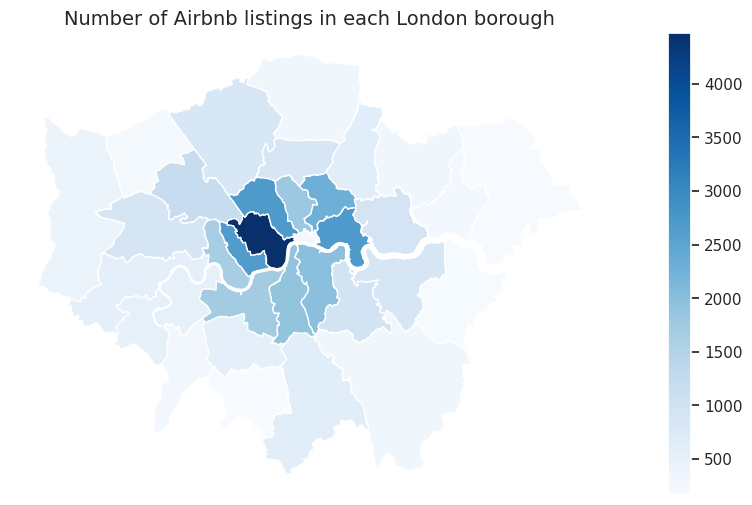

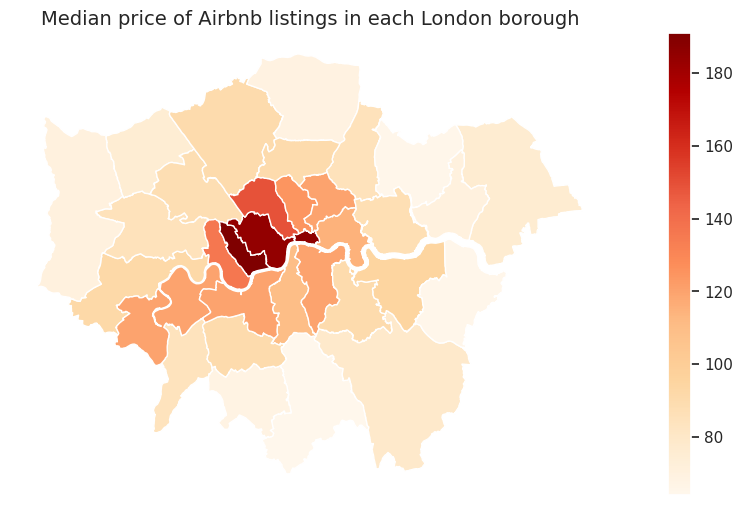

In [190]:
map_df = gpd.read_file('https://raw.githubusercontent.com/xiaohansu59/thesis/main/data/neighbourhoods.geojson')
map_df.drop('neighbourhood_group', axis=1, inplace=True)

df = df_listing.copy()
df = df[df['room_type'] != 'Hotel room']

# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df.groupby('neighbourhood_cleansed').size())
borough_df.rename(columns={0:'number_of_listings'},inplace=True)
borough_df['median_price'] = df.groupby('neighbourhood_cleansed').price.median().values
# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)

# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each London borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(borough_map_df.number_of_listings), vmax=max(borough_map_df.number_of_listings)))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='OrRd', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each London borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

In [194]:
df_listing.sample()

,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,name_missing,description_missing,neighborhood_overview_missing,host_location_missing,host_about_missing,host_acceptance_rate_missing,host_neighbourhood_missing,bedrooms_missing,beds_missing,bathrooms_count_missing
id,,,,,,,,,,,,,,,,,,,,,
775174203495040482,477820514,within a few hours,0.99,0.89,0.0,66.0,77.0,1,1,Tower Hamlets,...,0,0,0,1,1,0,0,0,0,0


In [ ]:
df_listing['host_response_time'].fillna('unknown',inplace=True)
df_listing = pd.get_dummies(df_listing)
df_listing.shape

(36636, 185)

In [ ]:
# df_listing[['neighbourhood_cleansed_Westminster']].value_counts()
# df_listing.nunique()

### Numerical features

In [ ]:
nulls = df_listing.isnull().sum()
nulls = nulls[nulls!=0]
nulls

host_response_rate             3516
host_acceptance_rate            405
host_is_superhost                 1
bedrooms                       1776
beds                            467
review_scores_accuracy            1
review_scores_cleanliness         3
review_scores_checkin             1
review_scores_communication       2
review_scores_location            1
review_scores_value               1
bathrooms_count                  32
description_length              372
dtype: int64

In [ ]:
df_listing['host_is_superhost'].fillna(0,inplace=True)

In [ ]:
# fillna with median for columns that have zero
# and zero for those that don't have zero

def fill_na(df):
    col = df.columns
    for x in col:
        if df[x].isnull().sum()>0:
            if df[df[x]==0][x].count()==0:
                df[x].fillna(0, inplace=True)
                print("fill nulls with 0 for:", x)
            else:
                df[x].fillna(df[x].median(), inplace=True)
                print("fill nulls with median for:", x)

fill_na(df_listing)

fill nulls with median for: host_response_rate
fill nulls with median for: host_acceptance_rate
fill nulls with 0 for: bedrooms
fill nulls with 0 for: beds
fill nulls with 0 for: review_scores_accuracy
fill nulls with 0 for: review_scores_cleanliness
fill nulls with 0 for: review_scores_checkin
fill nulls with 0 for: review_scores_communication
fill nulls with 0 for: review_scores_location
fill nulls with 0 for: review_scores_value
fill nulls with median for: bathrooms_count
fill nulls with 0 for: description_length


In [ ]:
sum(df_listing.isnull().sum())

0

## Amenities

In [ ]:
amenities_df['amenities'].head()

id
825491308329325404    [washer, first aid kit, fire extinguisher, smo...
786791705194673775                                [washer, tv, kitchen]
749834503531737273    [washer, smoke alarm, free parking on premises...
717113207077160928                              [outdoor furniture, tv]
50584271              [washer, outdoor furniture, hangers, dishwashe...
Name: amenities, dtype: object

In [ ]:
# to_1D(amenities_df['amenities']).value_counts().head(300)

In [ ]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

amenities_counts = to_1D(amenities_df['amenities']).value_counts().head(300).reset_index()
amenities_counts = amenities_counts.rename(columns={'index': 'amenity', 0: 'count'})

amenities_counts

,amenity,count
0,smoke alarm,34236
1,kitchen,33010
2,essentials,32465
3,wifi,32398
4,iron,29299
...,...,...
295,fast wifi – 72 mbps,55
296,heating - split type ductless system,55
297,"32"" hdtv with standard cable",54
298,siemens stainless steel oven,54


In [ ]:
amenities_df.shape

(36636, 2)

In [ ]:
amenities_list = to_1D(amenities_df['amenities']).value_counts().head(300).index

def onehot_df(df, variable, unique_items):
    """
    Performs one-hot encoding on a specified column in a DataFrame, using a given list of unique items.
    It creates new columns for each unique item and deletes the original column.
    """
    item_lists = df[variable]
    for i, label in enumerate(unique_items):
        df[variable+'_'+label] = item_lists.apply(lambda x: 1 if label in x else 0)
    del df[variable]
    return df

amenities_df = onehot_df(amenities_df, 'amenities', amenities_list)

In [ ]:
amenities_df.drop(['listing_url'],axis=1,inplace=True)
amenities_df.shape

(36636, 300)

In [ ]:
# take a look at the head of the one-hot encoding result for 'amenities'
df = amenities_df.head(3)
df.rename_axis('listing_id', inplace=True)
df.T

listing_id,825491308329325404,786791705194673775,749834503531737273
amenities_smoke alarm,1,0,1
amenities_kitchen,1,1,0
amenities_essentials,0,0,0
amenities_wifi,1,0,1
amenities_iron,0,0,0
...,...,...,...
amenities_fast wifi – 72 mbps,0,0,0
amenities_heating - split type ductless system,0,0,0
"amenities_32"" hdtv with standard cable",0,0,0
amenities_siemens stainless steel oven,0,0,0


In [ ]:
# columns = [
#     'amenities_smoke alarm','amenities_kitchen','amenities_essentials','amenities_wifi','amenities_iron',
#     'amenities_hot water','amenities_hangers','amenities_dishes and silverware','amenities_hair dryer',
#     'amenities_carbon monoxide alarm'
# ]

# for col in columns:
#     print(f"\nValue counts for '{col}':")
#     display(amenities_df[col].value_counts().to_frame())


# amenities_df.nunique().value_counts()

In [ ]:
df_listing.shape

(36636, 185)

In [ ]:
# merge the two dataframes
df_listing = df_listing.join(amenities_df, how='left')
df_listing.reset_index(inplace=True)
df_listing.head(3)

,id,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,...,amenities_faith in nature conditioner,amenities_outdoor kitchen,"amenities_40"" hdtv",amenities_aesop body soap,amenities_fast wifi – 74 mbps,amenities_fast wifi – 72 mbps,amenities_heating - split type ductless system,"amenities_32"" hdtv with standard cable",amenities_siemens stainless steel oven,amenities_faith in nature shampoo
0,825491308329325404,500808473,1.00,1.00,0.0,1.0,1.0,0,0,51.416047,...,0,0,0,0,0,0,0,0,0,0
1,786791705194673775,490795350,0.98,0.87,0.0,25.0,26.0,0,1,51.370691,...,0,0,0,0,0,0,0,0,0,0
2,749834503531737273,407681693,1.00,1.00,0.0,2.0,4.0,1,1,51.613340,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_listing.shape

(36636, 486)

## Multi listing

In [ ]:
listing_by_host = host_id_df.groupby('host_id').size().reset_index(name='count')
listing_by_host.head()

,host_id,count
0,4775,7
1,4879,1
2,6774,5
3,9323,1
4,10115,2


In [ ]:
listing_by_host['count'].describe().round(2)

count    21138.00
mean         1.73
std          3.52
min          1.00
25%          1.00
50%          1.00
75%          1.00
max        167.00
Name: count, dtype: float64

In [ ]:
listing_by_host['is_multi_listing'] = listing_by_host['count'].map(lambda x:1 if x>1 else 0)
listing_by_host.head()

,host_id,count,is_multi_listing
0,4775,7,1
1,4879,1,0
2,6774,5,1
3,9323,1,0
4,10115,2,1


In [ ]:
listing_by_host['is_multi_listing'].value_counts()

0    16354
1     4784
Name: is_multi_listing, dtype: int64

In [ ]:
listing_by_host.drop(['count'],axis=1,inplace=True)
listing_by_host.shape

(21138, 2)

In [ ]:
df_listing.shape

(36636, 486)

In [ ]:
df_listing = pd.merge(df_listing,listing_by_host,on='host_id',how='left')
df_listing.shape

(36636, 487)

In [ ]:
df_listing.isnull().sum().sum()

0

In [ ]:
# df_listing[['multi_listing']].head()
# df_listing[['multi_listing']].value_counts()

## Sentiment analysis on reviews

In [ ]:
# df_review = pd.read_csv('data/reviews.csv', encoding='utf-8')
# df_review.shape

In [ ]:
df_review = pd.read_csv('http://data.insideairbnb.com/united-kingdom/england/london/2023-03-14/data/reviews.csv.gz', encoding='utf-8')
df_review.shape

(1352432, 6)

In [ ]:
df_review.isnull().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      0
comments         106
dtype: int64

In [ ]:
df_review = df_review.dropna(subset=['comments'])
df_review.shape

(1352326, 6)

In [ ]:
# df_review[df_review['comments'].str.len()==2]

In [ ]:
df_review['comments'] = df_review['comments'].apply(remove_html_tags)
df_review = df_review[df_review['comments'].str.len()>1]
df_review.shape

(1349418, 6)

### Comment length

In [ ]:
df_review['comments_length'] = df_review['comments'].str.split().apply(len)
df_review[['comments','comments_length']].head()

,comments,comments_length
0,My girlfriend and I hadn't known Alina before ...,149
1,Alina was a really good host. The flat is clea...,32
2,Alina is an amazing host. She made me feel rig...,68
3,"Alina's place is so nice, the room is big and ...",86
4,"Nice location in Islington area, good for shor...",17


### Detect language & filter only English

In [ ]:
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

df_review['language'] = df_review['comments'].apply(language_detection)
df_review['language'].value_counts().head(10)

en       1174019
fr         56244
es         29681
de         20522
it         12439
ko          9626
zh-cn       7844
pt          6443
nl          4802
ro          3447
Name: language, dtype: int64

In [ ]:
df_review = df_review[df_review['language']=='en'].reset_index(drop=True)
df_review.shape

(1174019, 8)

### Sentiment scores

In [ ]:
def textblob_sentiment_scores(text):
    textblob_sentiment = TextBlob(text)
    score = textblob_sentiment.sentiment.polarity
    return score

df_review['TextBlob_sentiment_score'] = df_review['comments'].apply(textblob_sentiment_scores)
df_review['TextBlob_sentiment_score'].describe().round(2)

count    1174019.00
mean           0.41
std            0.20
min           -1.00
25%            0.29
50%            0.40
75%            0.52
max            1.00
Name: TextBlob_sentiment_score, dtype: float64

In [ ]:
# plt.figure(figsize=(6, 3))
# sns.boxplot(x=df_review['textblob_score'], showfliers=False)
# plt.title('Box plot of TextBlob sentiment scores (outliers excluded)')
# plt.show()

### Drop automated postings

In [ ]:
# df_review[df_review['comments'].str.contains(
#     'This is an automated posting.')][['comments']].reset_index(drop=True)

In [ ]:
df_review = df_review[~df_review['comments'].str.contains('This is an automated posting.')].reset_index(drop=True)
df_review.shape

(1162010, 9)

### Key reviewers (having reviews more than 1)

In [ ]:
reviewer = df_review.groupby('reviewer_id').size().reset_index(name='number_of_reviews')
reviewer.head()

,reviewer_id,number_of_reviews
0,259,1
1,283,1
2,287,2
3,333,1
4,706,1


In [ ]:
reviewer['number_of_reviews'].describe().round(2)

count    973353.00
mean          1.19
std           0.83
min           1.00
25%           1.00
50%           1.00
75%           1.00
max         133.00
Name: number_of_reviews, dtype: float64

In [ ]:
# reviewer[reviewer['count']>1].reset_index(drop=True)

In [ ]:
key_reviewer = reviewer[reviewer['number_of_reviews']>1].reset_index(drop=True)['reviewer_id'].values
df_review['is_key_reviewer'] = np.where(df_review['reviewer_id'].isin(key_reviewer), 1, 0)
df_review[['reviewer_id','is_key_reviewer']].head()

,reviewer_id,is_key_reviewer
0,177109,0
1,19835707,1
2,1110304,0
3,1216358,0
4,490840,0


In [ ]:
review_group = df_review[['listing_id','comments_length','TextBlob_sentiment_score',
                          'is_key_reviewer']].groupby(by='listing_id').mean()
review_group.head()

,comments_length,TextBlob_sentiment_score,is_key_reviewer
listing_id,,,
13913,40.125000,0.426355,0.450000
15400,73.988372,0.393211,0.209302
17402,74.386364,0.406447,0.136364
24328,68.000000,0.408263,0.130952
25123,59.898148,0.391549,0.250000


In [ ]:
# review_group.to_csv('data/reviews_clean.csv')

In [ ]:
review_group = pd.read_csv('https://raw.githubusercontent.com/xiaohansu59/thesis/main/data/reviews_clean.csv')

In [ ]:
# merge these two dataframes
df_listing = df_listing.rename(columns={'id':'listing_id'})
merged_df = df_listing.merge(
    review_group, on='listing_id', how='left')
merged_df.shape

(36636, 490)

In [ ]:
merged_df.columns[merged_df.isnull().sum()>0]

Index(['comments_length', 'TextBlob_sentiment_score', 'is_key_reviewer'], dtype='object')

In [ ]:
columns=['comments_length','TextBlob_sentiment_score','is_key_reviewer']
for col in columns:
    merged_df[col] = merged_df[col].fillna(merged_df[col].mean())
merged_df.isnull().sum().sum()

0

## Normalized space for longitude and latitude

In [ ]:
lat, lon = merged_df['latitude'], merged_df['longitude']
merged_df['geo_x'] = np.multiply(np.cos(lat), np.cos(lon))
merged_df['geo_y'] = np.multiply(np.cos(lat), np.sin(lon))
merged_df['geo_z'] = np.sin(lat)
merged_df[['latitude','longitude','geo_x','geo_y','geo_z']].head()

,latitude,longitude,geo_x,geo_y,geo_z
0,51.416047,-0.174299,0.401790,-0.070749,0.912995
1,51.370691,-0.109956,0.446237,-0.049265,0.893558
2,51.613340,-0.125910,0.219346,-0.027765,0.975252
3,51.640408,-0.188166,0.191185,-0.036405,0.980879
4,51.401850,-0.255760,0.407201,-0.106478,0.907111


In [ ]:
merged_df.shape

(36636, 493)

## Log transform price

In [ ]:
merged_df['price'].describe().round(2)

count    36636.00
mean       170.58
std        301.04
min         10.00
25%         70.00
50%        120.00
75%        195.00
max      35243.00
Name: price, dtype: float64

In [ ]:
# plt.figure(figsize=(6, 3))
# sns.boxplot(x=merged_df['price'],showfliers=False)
# plt.title('Boxplot of listing prices (outlier excluded)')
# plt.show()

In [ ]:
stat, p = shapiro(merged_df['price'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.264, p=0.000
Sample does not look Gaussian (reject H0)


In [ ]:
merged_df['log_price'] = np.log(merged_df['price'])
merged_df['log_price'].describe()

count    36636.000000
mean         4.798676
std          0.754045
min          2.302585
25%          4.248495
50%          4.787492
75%          5.273000
max         10.470022
Name: log_price, dtype: float64

In [195]:
# sns.distplot(merged_df['log_price'], fit=norm);
# fig = plt.figure()
# res = stats.probplot(merged_df['log_price'], plot=plt)
# #skewness and kurtosis
# print("Skewness: %f" % merged_df['log_price'].skew())
# print("Kurtosis: %f" % merged_df['log_price'].kurt())

In [ ]:
# merged_df['price'].hist(figsize=(6,4))
# plt.title('Histogram of Prices (before Log-transformed)')
# plt.show()

In [ ]:
# merged_df['price_log'].hist(figsize=(6,4))
# plt.title('Histogram of Prices (after Log-transformed)')
# plt.show()

In [ ]:
# merged_df.to_csv('data/airbnb_clean.csv',index=False)

In [ ]:
merged_df = pd.read_csv('data/airbnb_clean.csv')

## Add some OpenStreetMap features ('attraction' & 'restaurant' within certain distance from a listing)

In [ ]:
map_df = gpd.read_file('https://raw.githubusercontent.com/xiaohansu59/thesis/main/data/neighbourhoods.geojson')
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Kingston upon Thames,NaN,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
1,Croydon,NaN,"MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51..."
2,Bromley,NaN,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2..."
3,Hounslow,NaN,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51..."
4,Ealing,NaN,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51..."


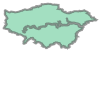

In [ ]:
region = map_df['geometry'].unary_union
region

In [ ]:
type(region)

shapely.geometry.polygon.Polygon

In [ ]:
def get_local_crs(y,x):
    x = ox.utils_geo.bbox_from_point((y, x), dist=500, project_utm=True, return_crs=True)
    return x[-1]

london_latitude = 51.509865
london_longitude = -0.118092
local_utm_crs = get_local_crs(london_latitude, london_longitude)
local_utm_crs

<Projected CRS: +proj=utm +zone=30 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
def get_osm_data(region, data):
    df = ox.features.features_from_polygon(region, tags=data[0])
    filename = f"data/{list(data[0].values())[0]}.csv"
    df.to_csv(filename, columns=['geometry'])
    return df

# attraction = get_osm_data(region, [{'tourism':'attraction'}])
# restaurant = get_osm_data(region, [{'amenity':'restaurant'}])

In [ ]:
def import_csv_to_gpd(name):
    df = pd.read_csv(f'data/{name}.csv', sep=",")
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, crs='epsg:4326')
    return gdf

restaurant = import_csv_to_gpd('restaurant')
attraction = import_csv_to_gpd('attraction')

In [ ]:
restaurant.head()

,element_type,osmid,geometry
0,node,451153,POINT (-0.19350 51.60203)
1,node,26544484,POINT (-0.17223 51.39801)
2,node,26603928,POINT (-0.48171 51.52718)
3,node,26604024,POINT (-0.45855 51.52573)
4,node,26845558,POINT (-0.13256 51.51105)


In [ ]:
attraction.head()

,element_type,osmid,geometry
0,node,26559743,POINT (-0.14525 51.39520)
1,node,252602371,POINT (-0.08826 51.50639)
2,node,269236138,POINT (-0.17065 51.35530)
3,node,293221901,POINT (0.16023 51.44819)
4,node,320446994,POINT (-0.18974 51.56601)


In [ ]:
def get_long_lat(point):
    try:
        return pd.Series([point.x, point.y])
    except:
        pass

def geo_coordinates(df):
    df['geometry'] = df['geometry'].apply(
        lambda x: x.centroid if type(x) == Polygon else (x.centroid if type(x) == MultiPolygon else x))
    df[['long','lat']] = df.apply(lambda x: get_long_lat(x['geometry']), axis=1)
    df = df[df['geometry'].apply(lambda x: x.geom_type=='Point')]
    df = df.to_crs(local_utm_crs)
    return df

attraction = geo_coordinates(attraction)
restaurant = geo_coordinates(restaurant)

In [ ]:
restaurant.head()

,element_type,osmid,geometry,long,lat
0,node,451153,POINT (694353.653 5720508.222),-0.193503,51.602031
1,node,26544484,POINT (696703.089 5697881.898),-0.172235,51.398014
2,node,26603928,POINT (674684.450 5711457.900),-0.481714,51.527176
3,node,26604024,POINT (676296.779 5711352.878),-0.458548,51.525732
4,node,26845558,POINT (698970.076 5710557.083),-0.132560,51.511054


In [ ]:
attraction.head()

,element_type,osmid,geometry,long,lat
0,node,26559743,POINT (698592.310 5697642.316),-0.145245,51.395205
1,node,252602371,POINT (702063.779 5710159.680),-0.088264,51.506388
2,node,269236138,POINT (696996.687 5693137.398),-0.170649,51.355303
3,node,293221901,POINT (719583.801 5704404.661),0.160226,51.448185
4,node,320446994,POINT (694768.016 5716513.543),-0.189743,51.566012


In [ ]:
def get_tree(df):
    try:
        coords = list(zip(df.geometry.apply(lambda x: x.y).values, df.geometry.apply(lambda x: x.x).values))
        tree = spatial.KDTree(coords)
        return tree
    except Exception as e:
        print(e)

def find_points_closeby(tree, lat_lon, k=500, max_distance=800):
    results = tree.query(lat_lon, k=k, distance_upper_bound=max_distance)
    zipped_results = list(zip(results[0], results[1]))
    zipped_results = [i for i in zipped_results if i[0] != np.inf]
    return len(zipped_results)

merged_df = gpd.GeoDataFrame(
    merged_df, geometry=gpd.points_from_xy(merged_df['longitude'],
                                           merged_df['latitude']), crs=4326)
merged_df = merged_df.to_crs(local_utm_crs)

parameters = [attraction, restaurant]
names = ['number_of_nearby_attractions', 'number_of_nearby_restaurants']
for name, i in zip(names, parameters):
    tree = get_tree(i)
    merged_df[name] = merged_df.apply(
        lambda row: find_points_closeby(
            tree, (row.geometry.y, row.geometry.x)), axis=1)

In [ ]:
merged_df[['listing_id'] + names].head()

,listing_id,number_of_nearby_attractions,number_of_nearby_restaurants
0,825491308329325404,0,17
1,786791705194673775,0,14
2,749834503531737273,0,2
3,717113207077160928,0,1
4,50584271,0,16


In [ ]:
# merged_df.to_csv('data/airbnb_osm.csv',index=False)

# Model

In [3]:
merged_df = pd.read_csv('data/airbnb_osm.csv')

In [4]:
merged_df = merged_df[merged_df['room_type_Hotel room'] != 1]
merged_df.shape

(36512, 497)

In [53]:
X = merged_df.drop(columns=['price','log_price','listing_id','host_id','latitude','longitude','geometry'])
y = merged_df['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(29209, 490) (7303, 490)
(29209,) (7303,)


## Linear Regression (Baseline)

In [6]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print(f'MSE train: {mean_squared_error(y_train,y_train_pred):.3f}')
print(f'MSE test: {mean_squared_error(y_test,y_test_pred):.3f}')
print(f'\nR2 train: {r2_score(y_train, y_train_pred):.3f}')
print(f'R2 test: {r2_score(y_test, y_test_pred):.3f}')

MSE train: 0.131
MSE test: 0.129

R2 train: 0.770
R2 test: 0.771


## Random Forest

In [7]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print(f'MSE train: {mean_squared_error(y_train, y_train_pred):.3f}')
print(f'MSE test: {mean_squared_error(y_test, y_test_pred):.3f}')
print(f'\nR2 train: {r2_score(y_train, y_train_pred):.3f}')
print(f'R2 test: {r2_score(y_test, y_test_pred):.3f}')

MSE train: 0.016
MSE test: 0.108

R2 train: 0.972
R2 test: 0.809


## XGBoost

In [57]:
xgbr = xgb.XGBRegressor(random_state=42)
xgbr.fit(X_train, y_train)
y_train_pred = xgbr.predict(X_train)
y_test_pred = xgbr.predict(X_test)

print(f'MSE train: {mean_squared_error(y_train,y_train_pred):.3f}')
print(f'MSE test: {mean_squared_error(y_test,y_test_pred):.3f}')
print(f'\nR2 train: {r2_score(y_train, y_train_pred):.3f}')
print(f'R2 test: {r2_score(y_test, y_test_pred):.3f}')

MSE train: 0.045
MSE test: 0.096

R2 train: 0.921
R2 test: 0.830


In [58]:
# Manually change some parameters
xgbr = xgb.XGBRegressor(random_state=42,
                        n_estimators=400,
                        max_depth=3)
xgbr.fit(X_train, y_train)
y_train_pred = xgbr.predict(X_train)
y_test_pred = xgbr.predict(X_test)

print(f'MSE train: {mean_squared_error(y_train,y_train_pred):.3f}')
print(f'MSE test: {mean_squared_error(y_test,y_test_pred):.3f}')
print(f'\nR2 train: {r2_score(y_train, y_train_pred):.3f}')
print(f'R2 test: {r2_score(y_test, y_test_pred):.3f}')

MSE train: 0.064
MSE test: 0.095

R2 train: 0.887
R2 test: 0.832


### Tuning the model with RandomizedSearchCV

In [10]:
def build_trained_model():

    parameters = {
        'n_estimators': list(range(50, 500, 50)), # default=100
        'max_depth': list(range(1, 10)), # default=6
        'learning_rate': list(np.linspace(0.01, 1, 20)) + [0.3], # default=0.3
        'subsample': [0.5, 0.7, 0.9, 1], # default=1
        }

    start_time = time.time()
    print("Testing the following parameter combinations:")

    total_iterations = 1
    for key, value in parameters.items():
        print(f"{key}: {value}")
        total_iterations *= len(value)

    model = xgb.XGBRegressor(random_state=42, tree_method='gpu_hist')

    # Set the number of iterations for RandomizedSearchCV
    n_iter = min(total_iterations, 50)  # Limit the maximum number of iterations

    random_search = RandomizedSearchCV(model, param_distributions=parameters, n_iter=n_iter,
                                       scoring='neg_mean_squared_error', n_jobs=-1, cv=5, random_state=42)

    random_search.fit(X_train, y_train)

    elapsed_time = time.time() - start_time
    print("\nRandomized search complete.")
    print(f"Elapsed time: {elapsed_time / 60:.2f} minutes")
    print("\nBest parameters found:")
    print(random_search.best_params_)

    return random_search

model = build_trained_model()

Testing the following parameter combinations:
n_estimators: [50, 100, 150, 200, 250, 300, 350, 400, 450]
max_depth: [1, 2, 3, 4, 5, 6, 7, 8, 9]
learning_rate: [0.01, 0.06210526315789474, 0.11421052631578947, 0.16631578947368422, 0.21842105263157896, 0.2705263157894737, 0.32263157894736844, 0.37473684210526315, 0.4268421052631579, 0.4789473684210527, 0.5310526315789474, 0.5831578947368421, 0.6352631578947369, 0.6873684210526316, 0.7394736842105263, 0.791578947368421, 0.8436842105263158, 0.8957894736842106, 0.9478947368421053, 1.0, 0.3]
subsample: [0.5, 0.7, 0.9, 1]

Randomized search complete.
Elapsed time: 7.56 minutes

Best parameters found:
{'subsample': 0.9, 'n_estimators': 450, 'max_depth': 9, 'learning_rate': 0.06210526315789474}


In [59]:
best_model = model.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print(f'MSE train: {mean_squared_error(y_train, y_train_pred):.3f}')
print(f'MSE test: {mean_squared_error(y_test, y_test_pred):.3f}')
print(f'\nR2 train: {r2_score(y_train, y_train_pred):.3f}')
print(f'R2 test: {r2_score(y_test, y_test_pred):.3f}')

MSE train: 0.009
MSE test: 0.086

R2 train: 0.984
R2 test: 0.847


In [64]:
# xgb_feature_importances = pd.DataFrame(
#     zip(X_train.columns, best_model.feature_importances_),
#     columns=['Feature','Importance_score_xgb']).sort_values(by='Importance_score_xgb',ascending=False)
# xgb_feature_importances = xgb_feature_importances.reset_index(drop=True)
# xgb_feature_importances.head(10)

In [25]:
# xgb_feature_importances.to_csv('data/xgb_feature_importance.csv', index=False)